In [1]:
import numpy as np 
import pysindy as ps 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, RationalQuadratic, Matern, DotProduct

from matplotlib import style
style.use('seaborn-white')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

In [2]:

df_IDM = pd.read_csv('myResults/ASTAZERO2/Exp/Model_1/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_IDM = df_IDM.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_IDM = pd.DataFrame(df_IDM)

df_GIPPS = pd.read_csv('myResults/ASTAZERO2/Exp/Model_2/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_GIPPS = df_GIPPS.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_GIPPS = pd.DataFrame(df_GIPPS)

df_FVDM_CTH = pd.read_csv('myResults/ASTAZERO2/Exp/Model_3/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_FVDM_CTH = df_FVDM_CTH.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_FVDM_CTH = pd.DataFrame(df_FVDM_CTH)

df_FVDM_SIG = pd.read_csv('myResults/ASTAZERO2/Exp/Model_4/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_FVDM_SIG = df_FVDM_SIG.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_FVDM_SIG = pd.DataFrame(df_FVDM_SIG)

In [3]:
df = pd.read_csv('Data/ASTAZERO/dataVehicle1.csv', header=None,low_memory=False, encoding='UTF-8')
df = df.rename(columns={0:"TIME",1:"LEAD_POS",2:"FOLLOW_POS",3:"LEAD_VEL",4:"FOLLOW_VEL",5:"LEAD_LENGTH"})
df = pd.DataFrame(df)
print(df)

         TIME      LEAD_POS    FOLLOW_POS  LEAD_VEL  FOLLOW_VEL  LEAD_LENGTH
0         1.0   4466.914835   4458.758374  0.021174    0.007862        5.196
1         1.1   4466.916899   4458.759248  0.020108    0.009621        5.196
2         1.2   4466.918861   4458.760291  0.019126    0.011245        5.196
3         1.3   4466.920728   4458.761491  0.018225    0.012739        5.196
4         1.4   4466.922510   4458.762833  0.017404    0.014105        5.196
...       ...           ...           ...       ...         ...          ...
11752  1176.2  27440.670420  27431.138280  0.042988    0.011987        5.196
11753  1176.3  27440.674690  27431.139230  0.042337    0.006957        5.196
11754  1176.4  27440.678880  27431.139640  0.041571    0.001273        5.196
11755  1176.5  27440.682990  27431.139710  0.040687    0.000000        5.196
11756  1176.6  27440.687010  27431.139710  0.039682    0.000000        5.196

[11757 rows x 6 columns]


In [4]:
############ Converting Python DataFrames to Numpy Arrays ############

t = np.asarray(df["TIME"])
leadPos = np.asarray(df['LEAD_POS']) # Leading vehicle position 
followPos = np.asarray(df['FOLLOW_POS']) # Follow vehicle position 
vlead = np.asarray(df['LEAD_VEL']) # Leading vehicle velocity
v = np.asarray(df['FOLLOW_VEL']) # Follow vehicle velocity
leadLen = np.asarray(df["LEAD_LENGTH"]) # lead vehicle length 
leadVehLen = df.iat[0,5]
s = leadPos - followPos - leadLen[0]
#dt = t[1] - t[0]
dt = 0.1

sCheck = s<=0   # making sure that it is positive 
vehLen = leadLen!=5.196000000000001  # check if all the vehicles have the same length 
print(np.count_nonzero(vehLen)) # count the number of True 
print(np.count_nonzero(sCheck)) # count number of True 

statTrajec = 0
endTrajec = -1

#t = np.linspace(0, 188.9, 1889, endpoint=False)
t = t[statTrajec:endTrajec]

# Without Scaling 
v = v[statTrajec:endTrajec]
s = s[statTrajec:endTrajec]
vlead = vlead[statTrajec:endTrajec]

followPos = followPos[statTrajec:endTrajec]
leadPos = leadPos[statTrajec:endTrajec]

############ Calculating the Follower Derivative ############

FD = ps.SmoothedFiniteDifference()
v_p = FD(v, t) #HDWY Derivative #(670,1)
v_p = np.reshape(v_p, (v.size,)) #(670,)

11757
0


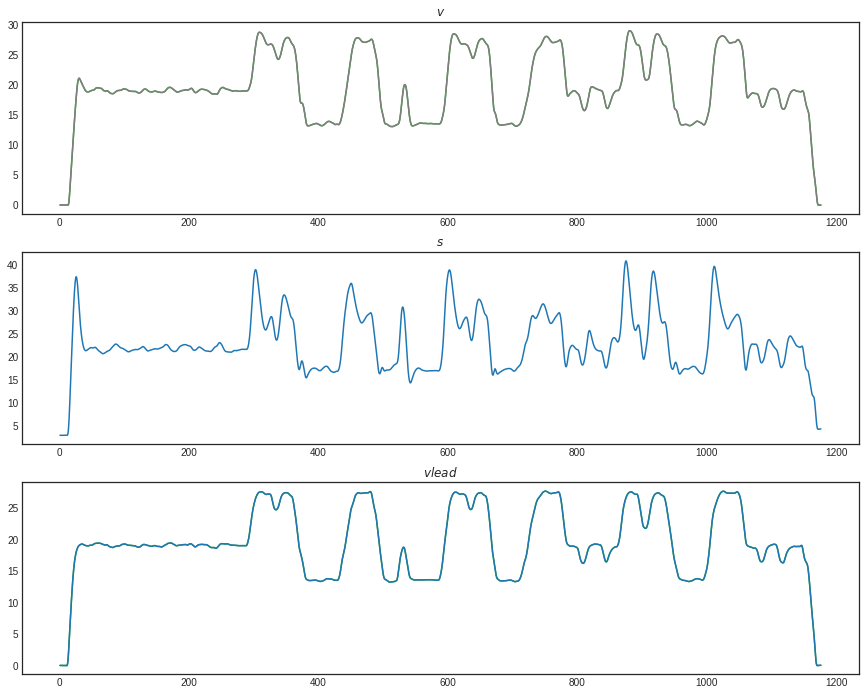

In [5]:
# Plotting the data
# plt.rc('font', size=10)
fig, (ax1,ax2,ax3) = plt.subplots(3)

statTraj = 0 #7000
endsTraj = -1 #8900

FD_v = FD(followPos[statTraj:endsTraj],t[statTraj:endsTraj])
FD_vlead = FD(leadPos[statTraj:endsTraj],t[statTraj:endsTraj])

fig.set_figheight(12)
fig.set_figwidth(15)
#ax1.plot(t[vehCon][statTraj:endsTraj], v[vehCon][statTraj:endsTraj])
ax1.plot(t[statTraj:endsTraj], v[statTraj:endsTraj], 'tab:green')
ax1.plot(t[statTraj:endsTraj], FD_v.reshape(followPos[statTraj:endsTraj].shape[0],)[:], 'tab:gray')
ax1.set_title('$v$')
#ax2.plot(t[statTraj:endsTraj], followPos[statTraj:endsTraj], 'tab:green')
ax2.plot(t[statTraj:endsTraj], s[statTraj:endsTraj])
#ax2.plot(t[statTraj:endsTraj], leadPos[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead[statTraj:endsTraj], 'tab:green')
ax3.plot(t[statTraj:endsTraj], FD_vlead.reshape(leadPos[statTraj:endsTraj].shape[0],)[:])
ax3.set_title('$vlead$')

plt.show()

# Kernel-Ridge

In [6]:
#st_Traj = 0
#en_Traj = 9405

# Training (UnStandardized)

#X_train = np.stack((v[st_Traj:en_Traj],s[st_Traj:en_Traj],vlead[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

#Y_train = v_p[st_Traj:en_Traj].reshape(-1,1)  # RMSE(A)
#Y_train = v[st_Traj+1:en_Traj+1].reshape(-1,1)  # RMSE(V)
#Y_train = s[st_Traj+1:en_Traj+1].reshape(-1,1) # RMSE(S)

# Testing (UnStandardized)

#Y_test = v_p[en_Traj+1:].reshape(-1,1) # RMSE(A)
#Y_test = v[en_Traj+1:].reshape(-1,1)   # RMSE(V)
#Y_test = s[en_Traj+1:].reshape(-1,1)    # RMSE(S)

#X_prior = np.stack((v,s,vlead,t), axis=1) # Prior

In [7]:
st_Traj = 0
en_Traj = 9405

# Training (Standardized)
v_mean = v[st_Traj:en_Traj].mean()
v_stdev = v[st_Traj:en_Traj].std()

s_mean = s[st_Traj:en_Traj].mean()
s_stdev = s[st_Traj:en_Traj].std()

vlead_mean = vlead[st_Traj:en_Traj].mean()
vlead_stdev = vlead[st_Traj:en_Traj].std()

v_p_mean = v_p[st_Traj:en_Traj].mean()
v_p_stdev = v_p[st_Traj:en_Traj].std()  

X_train = np.stack(((v[st_Traj:en_Traj]-v_mean)/v_stdev,(s[st_Traj:en_Traj]-s_mean)/s_stdev,(vlead[st_Traj:en_Traj]-vlead_mean)/vlead_stdev,t[st_Traj:en_Traj]), axis=1)

#Y_train = ((v_p[st_Traj+1:en_Traj+1]-v_p_mean)/v_p_stdev).reshape(-1,1)  # RMSE(A)
#Y_train = ((v[st_Traj+1:en_Traj+1]-v_mean)/v_stdev).reshape(-1,1)  # RMSE(V)
Y_train = ((s[st_Traj+1:en_Traj+1]-s_mean)/s_stdev).reshape(-1,1) # RMSE(S)

# Testing (Standardized)

#Y_test = ((v_p[en_Traj+1:]-v_p_mean)/v_p_stdev).reshape(-1,1)  # RMSE(A)
#Y_test = ((v[en_Traj+1:]-v_mean)/v_stdev).reshape(-1,1)       # RMSE(V)
Y_test = ((s[en_Traj+1:]-s_mean)/s_stdev).reshape(-1,1)       # RMSE(S)

X_prior = np.stack(((v-v_mean)/v_stdev,(s-s_mean)/s_stdev,(vlead-vlead_mean)/vlead_stdev,t), axis=1) # Prior

In [65]:
#RatQuad = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
ExpSine = 1.0 * ExpSineSquared(length_scale=1.0,periodicity=3.0,length_scale_bounds=(0.1, 10.0),periodicity_bounds=(1.0, 10.0))
#rbf_ridge = ConstantKernel(constant_value=1.0) * RBF(length_scale=1.0)
#dotProd = ConstantKernel(0.1) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)))
#mat_ridge = ConstantKernel(constant_value=1.0) * Matern(length_scale=1.0)
kernel_ridge = KernelRidge(kernel=ExpSine)
kernel_ridge.get_params().keys()

dict_keys(['alpha', 'coef0', 'degree', 'gamma', 'kernel__k1', 'kernel__k2', 'kernel__k1__constant_value', 'kernel__k1__constant_value_bounds', 'kernel__k2__length_scale', 'kernel__k2__periodicity', 'kernel__k2__length_scale_bounds', 'kernel__k2__periodicity_bounds', 'kernel', 'kernel_params'])

In [66]:
param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__k1__constant_value": loguniform(1e0, 1e1),
    "kernel__k2__length_scale": loguniform(1e-2, 1e2), 
    "kernel__k2__periodicity": loguniform(1e-2, 1e2)
} 
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=200,
    random_state=0,
    n_jobs=1
    )

In [67]:
kernel_ridge_tuned.fit(X_train[:,:3], Y_train)
kRidge_tune_pred = kernel_ridge_tuned.predict(X_prior[:,:3])


Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


In [68]:
# save the model 
#with open('ResearchUpdate#43/kRidgeModels/ASTAZERO/kRidge_ExpSine_Stand_ASTA(S).pkl','wb') as f:
    pickle.dump(kernel_ridge_tuned,f)
kernel_ridge_tuned.best_params_  # prinintng the best learned parameters

{'alpha': 1.055971775974982,
 'kernel__k1__constant_value': 2.3587345571729865,
 'kernel__k2__length_scale': 1.324795542699921,
 'kernel__k2__periodicity': 48.80292442416498}

In [8]:
# loading the model
with open('ResearchUpdate#43/kRidgeModels/ASTAZERO/kRidge_RBF_Stand_ASTA(S).pkl', 'rb') as f:
    load_kRidge = pickle.load(f)
kRidge_tune_pred = load_kRidge.predict(X_prior[:,:3])

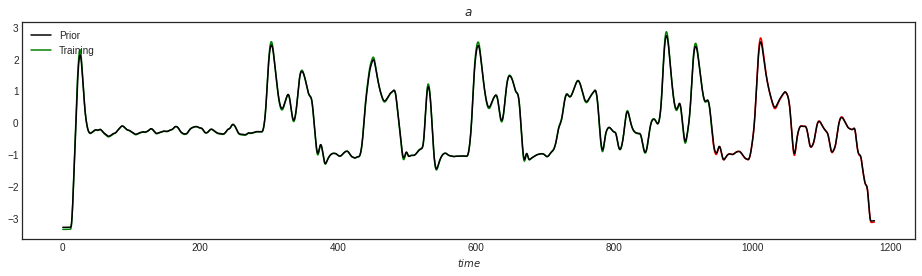

In [9]:
fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

p1, = ax.plot(X_train[:,3], Y_train, 'g')
ax.plot(t[en_Traj+1:], Y_test, 'r')
g1, = ax.plot(X_prior[:,3], kRidge_tune_pred, 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Prior', 'Training'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

# RMSE(S)

In [10]:
X_prior = np.stack(((v-v_mean)/v_stdev,(s-s_mean)/s_stdev,(vlead-vlead_mean)/vlead_stdev,t), axis=1) # Prior

In [11]:
kRidge_a = np.zeros(X_prior.shape[0])
kRidge_v = np.zeros(X_prior.shape[0])
kRidge_pos = np.zeros(X_prior.shape[0])
kRidge_s = np.zeros(X_prior.shape[0])

kRidge_a[0] = v_p[0]
kRidge_v[0] = v[0]
kRidge_pos[0] = followPos[0]
kRidge_s[0] = s[0]

for k in range(X_prior.shape[0]):
    if k != X_prior.shape[0]-1:
        kRidge_s[k+1] = load_kRidge.predict(X_prior[k,:3].reshape(1,-1))
        X_prior[k+1,1] = kRidge_s[k+1]
        kRidge_s[k+1] = kRidge_s[k+1]*s_stdev + s_mean  # Unstandardize
        kRidge_pos[k+1] = leadPos[k+1] - kRidge_s[k+1] - leadLen[0]
        kRidge_v[k+1] = (kRidge_pos[k+1]-kRidge_pos[k]) / 0.1
        X_prior[k+1,0] = (kRidge_v[k+1]-v_mean) / v_stdev
        kRidge_a[k+1] = (kRidge_v[k+1]-kRidge_v[k]) / 0.1

Train Acc. RMSE: 0.47831331900438584
Train Vel. RMSE 0.5973857982241846
Train Head. RMSE 3.4759705127236264
Test Acc. RMSE: 0.15795601320101452
Test Vel. RMSE 0.5005872079082109
Test Head. RMSE 3.261738722148724


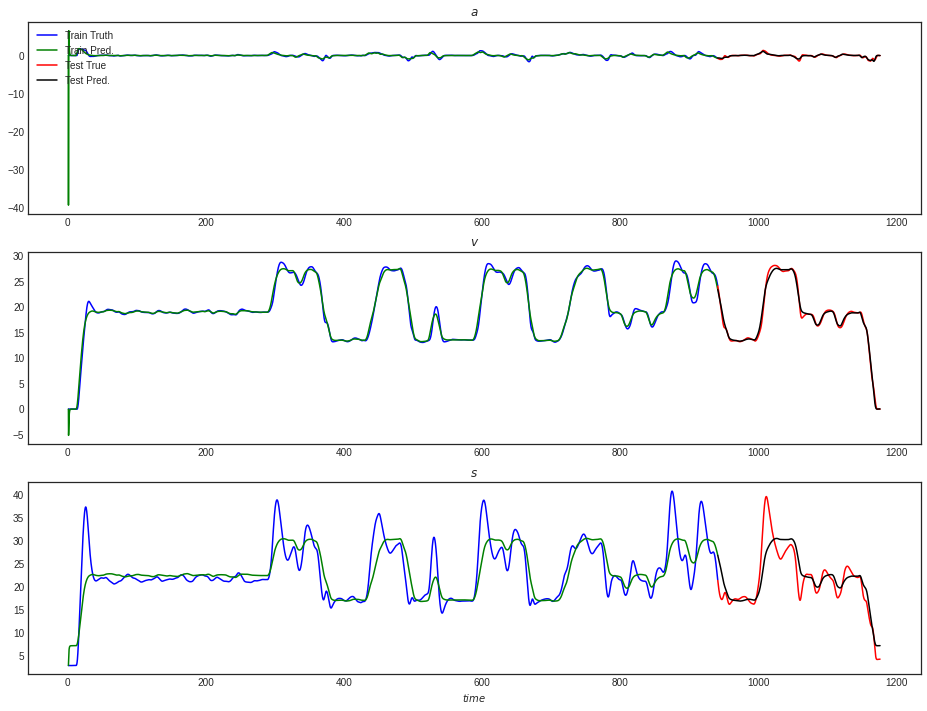

In [12]:
# Plotting 
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

print('Train Acc. RMSE:', np.sqrt(mean_squared_error(kRidge_a[:en_Traj], v_p[:en_Traj])))
print("Train Vel. RMSE", np.sqrt(mean_squared_error(kRidge_v[:en_Traj], v[:en_Traj])))
print("Train Head. RMSE", np.sqrt(mean_squared_error(kRidge_s[:en_Traj], s[:en_Traj])))

print('Test Acc. RMSE:', np.sqrt(mean_squared_error(kRidge_a[en_Traj:], v_p[en_Traj:])))
print("Test Vel. RMSE", np.sqrt(mean_squared_error(kRidge_v[en_Traj:], v[en_Traj:])))
print("Test Head. RMSE", np.sqrt(mean_squared_error(kRidge_s[en_Traj:], s[en_Traj:])))

fig, (ax1, ax2, ax3) = plt.subplots(3) 

fig.set_figheight(12)
fig.set_figwidth(16)

b1, = ax1.plot(X_train[:,3], v_p[:en_Traj], "b")
g1, = ax1.plot(X_prior[:en_Traj,3], kRidge_a[:en_Traj], "g")
r1, = ax1.plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax1.plot(X_prior[en_Traj:,3], kRidge_a[en_Traj:], "k")
ax1.set_title('$a$')

ax2.plot(X_train[:,3], v[:en_Traj], "b")
ax2.plot(X_prior[:en_Traj,3], kRidge_v[:en_Traj], "g")
ax2.plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax2.plot(X_prior[en_Traj:,3], kRidge_v[en_Traj:], "k")
#ax2.plot(X_prior[:,3], new_v, "m")
ax2.set_title('$v$')

ax3.plot(X_train[:,3], s[:en_Traj], "b")
ax3.plot(X_prior[:en_Traj,3], kRidge_s[:en_Traj], "g")
ax3.plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax3.plot(X_prior[en_Traj:,3], kRidge_s[en_Traj:], "k")
ax3.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
plt.savefig('ResearchUpdate#43/kRidgeModels/ASTAZERO/kRidge_RBF_Stand_ASTA(S).png')
plt.show()